<a href="https://colab.research.google.com/github/AmishiR/Amishi_rknec/blob/main/Zomato_Stock_prices_EDA_%7C%7C_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'zomato-stock-price-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5067316%2F8493091%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240524%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240524T080106Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D043dbfc8878bcaf942680fb043da3b817eefe977d4e691aca9c823577b05a28724fa52f5197b3553307e833e38fd7474e200a1d3355d8f322db69d0b04d5c1b077f9e3dd62fe259cb2af444cd506a53f2f68a4a9603561af87acacf3c68272fd8a3c169ae570278c8d91b861cda02e27678cde6eab5bbd026807323753499ecee918c9bfd163cb30a169999ff734f7f7f71ef235ab4c103cb67b618dc8f06506ed590c810fcba99d5d59bdc5be0923d1541744742d88304283b9cb64a882f1d185cf9f4db6d9807fa095651640a3b1ea6beb8e4b2d7efad1ca95ca9b941dacd8fcb982ea6b318868e5fd7d0917bf1788dbcc3e089e18f01b47f29981818248f9'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import r2_score, mean_squared_error

from IPython.core.display import display, HTML

from datetime import datetime

# Data exploration

In [ ]:
df = pd.read_csv("/kaggle/input/zomato-stock-price-dataset/Zomato Dataset.csv")

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,23-07-2021,116.000000,138.899994,115.000000,126.000000,126.000000,694895290
1,26-07-2021,126.349998,143.750000,125.300003,140.649994,140.649994,249723854
2,27-07-2021,141.699997,147.800003,127.750000,132.899994,132.899994,240341900
3,28-07-2021,131.000000,135.000000,123.550003,131.199997,131.199997,159793731
4,29-07-2021,134.949997,144.000000,132.199997,141.550003,141.550003,117973089


In [ ]:
df.shape

(698, 7)

In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,698.000000,698.000000,698.000000,698.000000,698.000000,6.980000e+02
mean,98.334384,100.335100,96.009026,98.047851,98.047851,6.630727e+07
std,40.592932,41.323650,39.612367,40.518441,40.518441,7.209595e+07
min,40.849998,44.400002,40.599998,41.650002,41.650002,0.000000e+00
25%,63.062499,64.224998,62.000000,62.887498,62.887498,2.981124e+07
50%,83.599998,85.549999,82.200001,83.900002,83.900002,4.708161e+07
75%,133.637497,135.687500,131.225002,133.250004,133.250004,7.465835e+07
max,205.800003,207.199997,194.500000,201.300003,201.300003,6.948953e+08


In [ ]:
df['Open'].value_counts()

Open
63.000000     8
54.700001     6
64.800003     4
64.199997     4
134.500000    4
             ..
53.349998     1
53.650002     1
59.000000     1
55.900002     1
190.000000    1
Name: count, Length: 546, dtype: int64

In [ ]:
survived_counts = df['Open'].value_counts().reset_index()
survived_counts.columns = ['Open', 'Count']

<Axes: xlabel='Open', ylabel='Count'>

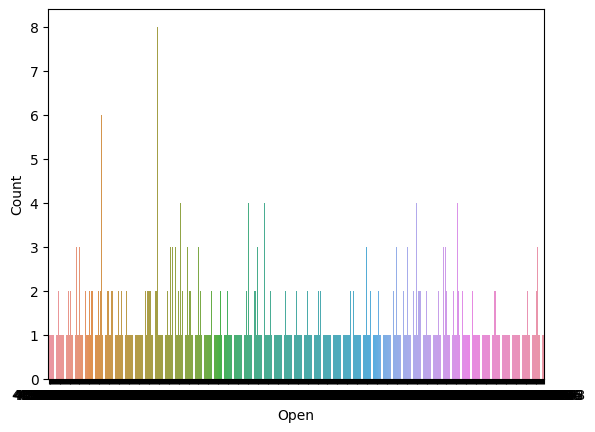

In [ ]:
sns.barplot(x='Open', y='Count', data=survived_counts)

(array([124., 163.,  82.,  61.,  42., 111.,  48.,  28.,  15.,  24.]),
 array([ 44.400002 ,  60.6800015,  76.960001 ,  93.2400005, 109.52     ,
        125.7999995, 142.079999 , 158.3599985, 174.639998 , 190.9199975,
        207.199997 ]),
 <BarContainer object of 10 artists>)

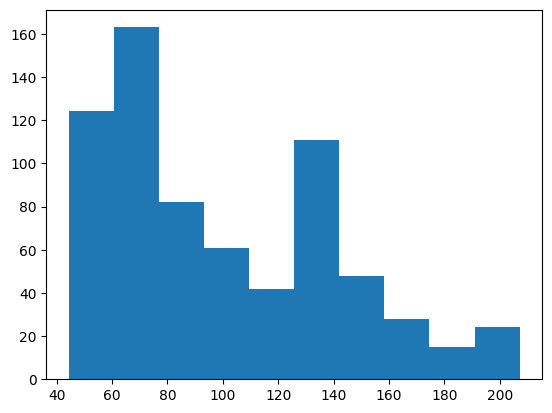

In [ ]:
plt.hist(df['High'], bins=10)

<Axes: xlabel='High', ylabel='Density'>

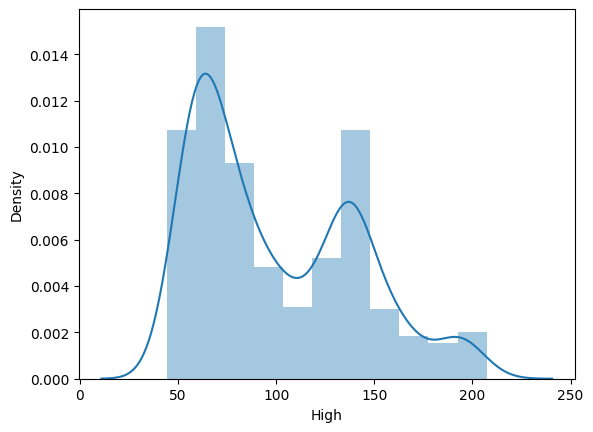

In [ ]:
sns.distplot(df['High'])

In [ ]:
df['High'].min()

44.400002

In [ ]:
df['High'].max()

207.199997

In [ ]:
df['High'].mean()

100.33510003008595

<Axes: xlabel='Open', ylabel='Low'>

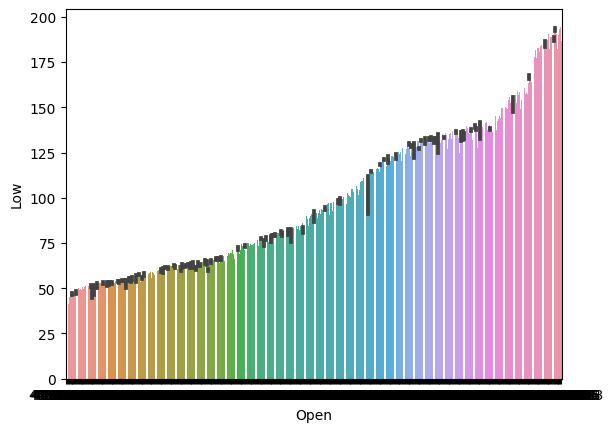

In [ ]:
sns.barplot(x='Open', y='Low', data=df)

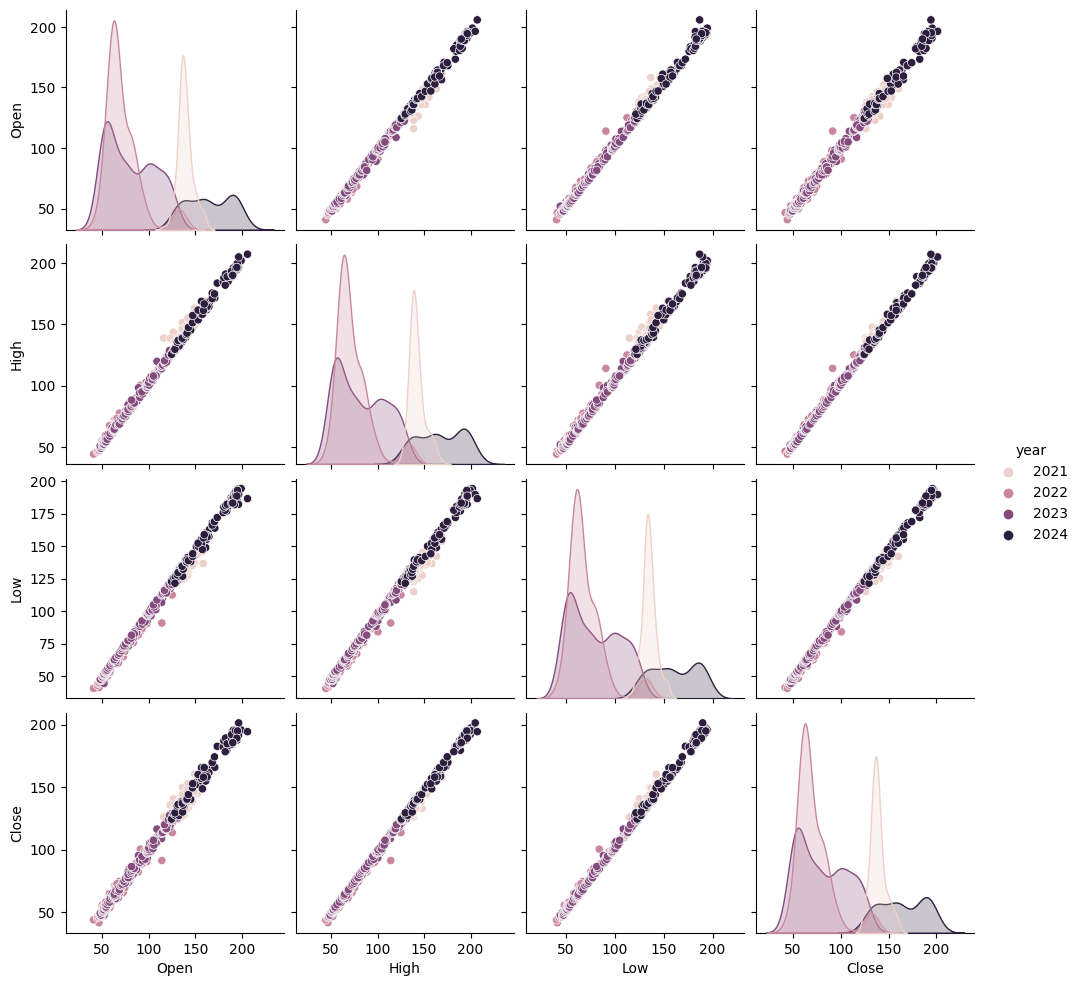

In [ ]:
sns.pairplot(df, vars=nums, hue="year")
plt.show()

In [ ]:
pd.crosstab(df['Open'], df['High'])

High,44.400002,46.299999,46.650002,47.200001,47.250000,48.549999,48.900002,49.099998,49.250000,50.549999,...,196.350006,196.500000,196.949997,197.699997,199.600006,199.699997,200.350006,202.000000,205.000000,207.199997
Open,,,,,,,,,,,,,,,,,,,,,
40.849998,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44.900002,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45.599998,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
46.599998,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
46.799999,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196.149994,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
196.350006,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
196.800003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
df.groupby('Low')['Close'].mean()*100

Low
40.599998      4395.000100
41.200001      4165.000200
43.049999      4570.000100
44.349998      4775.000000
44.549999      4679.999900
                  ...     
192.199997    19314.999400
192.750000    19544.999700
193.100006    19578.333533
194.050003    19689.999400
194.500000    19569.999700
Name: Close, Length: 557, dtype: float64